## First notebook

This notebook describes the original experiment with node ranges as well as trimming the node activations with the percentages and distance from mean

Library imports

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
use_cuda=True
from torchvision import datasets, transforms
from torch import nn, optim
import time
from tqdm import tqdm
import random
from scipy.stats import pointbiserialr

In [2]:
print("Available CUDA devices:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

Available CUDA devices: ['NVIDIA GeForce RTX 3090']


### Dataset

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])


trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)



In [4]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


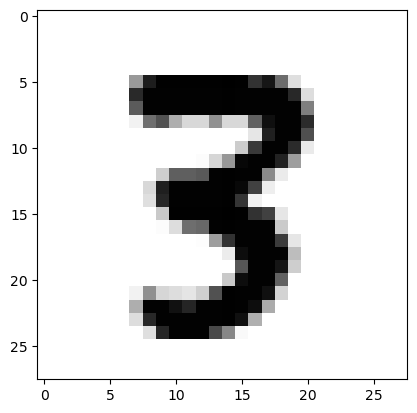

In [5]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');


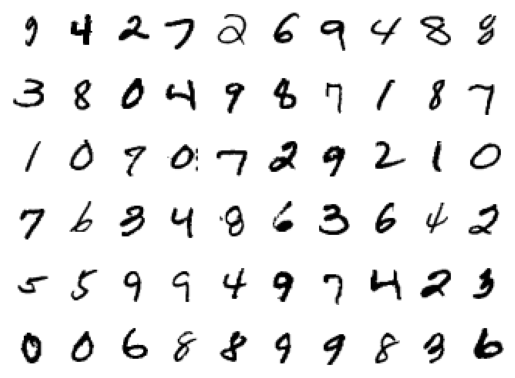

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')
    

### Useful functions

In [7]:
def train_model(model, trainloader, criterion, optimizer, epochs=15, device='cuda'):
    time0 = time.time()

    for e in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)

            # Training pass
            optimizer.zero_grad()

            output = model(images)
            loss = criterion(output, labels)

            # This is where the model learns by backpropagating
            loss.backward()

            # And optimizes its weights here
            optimizer.step()

            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))

    print("\nTraining Time (in minutes) =", (time.time()-time0)/60)

In [8]:
def extract_node_value_ranges_trim(model, num_nodes_per_layer, percent=5):
    if percent is None:
        return extract_node_value_ranges(model, num_nodes_per_layer, trim = False, n_std = 2)
    node_dict = model.node_dict
    interval_dict = create_network_dict(num_nodes_per_layer=num_nodes_per_layer)
    for layer, subdict in node_dict.items():
        for node, values in subdict.items():
            sorted_values = sorted(values)
        
            # Calculate the number of elements to trim
            num_to_trim = int(len(sorted_values) * (percent/100))

            # Trim the top and bottom values
            trimmed_values = sorted_values[num_to_trim:-num_to_trim]

            # Calculate min and max from trimmed values
            min_values = min(trimmed_values)
            max_values = max(trimmed_values)
            interval_dict[layer][node] = [min_values, max_values]
    return interval_dict

In [9]:
def evaluate_model_trim(model, valloader, percent=5, len_test = None):
    device='cuda'
    hidden_sizes = model.hidden_sizes
    value_ranges = extract_node_value_ranges_trim(model, num_nodes_per_layer=hidden_sizes,percent = percent)
    model.eval()
    model.testing = True
    model.reset_testing_dict()
    node_count = np.sum([len(subdict) for subdict in model.node_dict_testing.values()])
    k = 0
    correct_count, all_count = 0, 0
    percent_list = []
    prediction_list = []
    for images, labels in valloader:
        images, labels = images.to(device), labels.to(device)
        for index_to_test in range(images.shape[0]):
            img = images[index_to_test].view(1, -1)

            with torch.no_grad():
                logps = model(img)

                true_count = 0
                for layer, subdict in model.node_dict_testing.items():
                    for node, values in subdict.items():
                        min_value, max_value = value_ranges[layer][node]
                        if min_value <= values[all_count] <= max_value:
                            true_count += 1

                all_count += 1
                percent_true = true_count / node_count * 100
                percent_list.append(percent_true)
                true_count = 0

                ps = torch.exp(logps)
                probab = list(ps.detach().cpu().numpy()[0])
                pred_label = probab.index(max(probab))
                true_label = labels[index_to_test].detach().cpu().numpy()

                if true_label == pred_label:
                    prediction_list.append(True)
                    correct_count += 1
                else:
                    prediction_list.append(False)
        k+=64
        if len_test != None:
            if k>len_test:
                print("Breaking because k = ",k)
                break
                    

    accuracy = correct_count / all_count if all_count > 0 else 0.0
    return accuracy, percent_list, prediction_list



In [10]:
def extract_node_value_ranges(model, num_nodes_per_layer, trim, n_std):
    if trim == True:
        model.trim_node_values(n_std)
        node_dict = model.node_dict_trimmed
        sum_dict_original = sum(len(value) for layer in model.node_dict.values() for value in layer.values())
        sum_dict_trimmed = sum(len(value) for layer in model.node_dict_trimmed.values() for value in layer.values())
        print("Original = ", sum_dict_original, "node values")
        print("Trimmed = ", sum_dict_trimmed, "node values")
        print("Values removed =", sum_dict_original-sum_dict_trimmed)
        print("Percentage of nodes removed", 100*(sum_dict_original-sum_dict_trimmed)/sum_dict_original)
    else:
        node_dict = model.node_dict
    interval_dict = create_network_dict(num_nodes_per_layer=num_nodes_per_layer)
    for layer, subdict in node_dict.items():
        for node, values in subdict.items():
            min_values = min(values)
            max_values = max(values)
            interval_dict[layer][node] = [min_values, max_values]
    return interval_dict

In [11]:
def evaluate_model(model, valloader, trim = False, n_std = 2, len_test = None):
    device='cuda'
    hidden_sizes = model.hidden_sizes
    value_ranges = extract_node_value_ranges(model, num_nodes_per_layer=hidden_sizes, trim = trim, n_std = n_std)
    model.eval()
    model.testing = True
    model.reset_testing_dict()
    node_count = np.sum([len(subdict) for subdict in model.node_dict_testing.values()])

    correct_count, all_count = 0, 0
    percent_list = []
    prediction_list = []
    k=0

    for images, labels in valloader:
        images, labels = images.to(device), labels.to(device)

        for index_to_test in range(images.shape[0]):
            img = images[index_to_test].view(1, -1)

            with torch.no_grad():
                logps = model(img)

                true_count = 0
                for layer, subdict in model.node_dict_testing.items():
                    for node, values in subdict.items():
                        min_value, max_value = value_ranges[layer][node]
                        if min_value <= values[all_count] <= max_value:
                            true_count += 1

                all_count += 1
                percent_true = true_count / node_count * 100
                percent_list.append(percent_true)
                true_count = 0

                ps = torch.exp(logps)
                probab = list(ps.detach().cpu().numpy()[0])
                pred_label = probab.index(max(probab))
                true_label = labels[index_to_test].detach().cpu().numpy()

                if true_label == pred_label:
                    prediction_list.append(True)
                    correct_count += 1
                else:
                    prediction_list.append(False)
        k+=64
        if len_test != None:
            if k>len_test:
                print("Breaking because k = ",k)
                break

    accuracy = correct_count / all_count if all_count > 0 else 0.0
    return accuracy, percent_list, prediction_list



In [12]:
def plot_percentage_scatter(percentages, correct_predictions, num_points=None, ymin=0, ymax=102, title = None):
    
    


    # Plot points
    plt.figure(figsize=(12, 6))

    #progress_bar = tqdm(total=len(percentages), desc='Plotting')
    for i, (percent, correct) in enumerate(zip(percentages, correct_predictions)):
        marker = 'o' if correct else '^'
        color = 'green' if correct else 'red'
        plt.scatter(i + 1, percent, marker=marker, color=color, s=10, alpha=0.7)
        

        # Update the progress bar
        #progress_bar.update(1)
        #time.sleep(0.01)

    #progress_bar.close()

    plt.xlabel('Predictions')
    plt.ylabel('Percentage of True Nodes')
    if title == None:
        title = 'Scatter Plot of Percentage of True Nodes for Different Scenarios'
    plt.title(title)
    plt.ylim(ymin, ymax)

    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10),
                      plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='red', markersize=10)]
    legend_labels = ['Correct Prediction', 'Incorrect Prediction']

    # Show the legend with custom handles and labels
    plt.legend(handles=legend_handles, labels=legend_labels)

    # Show the plot
    plt.show()

# Sigmoid Model

In [13]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

def create_network_dict(num_nodes_per_layer):
    network_dict = {}
    for layer in range(1, len(num_nodes_per_layer) + 1):
        layer_name = f"Layer{layer}"
        network_dict[layer_name] = {f"node{i}": [] for i in range(num_nodes_per_layer[layer - 1])}
    return network_dict

class MyModel_sigmoid(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MyModel_sigmoid, self).__init__()

        self.layer1 = nn.Linear(input_size, hidden_sizes[0])
        self.sigmoid1 = nn.Sigmoid()
        self.layer2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.sigmoid2 = nn.Sigmoid()
        self.layer3 = nn.Linear(hidden_sizes[1], output_size)
        self.log_softmax = nn.LogSoftmax(dim=1)
        self.node_dict = create_network_dict(num_nodes_per_layer=hidden_sizes)
        self.node_dict_testing = create_network_dict(num_nodes_per_layer=hidden_sizes)
        self.testing = False
        self.hidden_sizes = hidden_sizes
        self.node_dict_trimmed = create_network_dict(num_nodes_per_layer=hidden_sizes)
        self.record = True

    def record_node_values(self, x, layer, hidden_sizes, record):
        if record:
            if self.testing:
                for j in range(len(x[0])):
                    self.node_dict_testing[f"Layer{layer}"][f"node{j}"].extend(x[:, j].detach().cpu().numpy())
            else:
                for j in range(len(x[0])):
                    self.node_dict[f"Layer{layer}"][f"node{j}"].extend(x[:, j].detach().cpu().numpy())

    def forward(self, x):
        layer = 1
        x = self.sigmoid1(self.layer1(x))
        self.record_node_values(x, layer, hidden_sizes, self.record)
        layer+=1
        x = self.sigmoid2(self.layer2(x))
        self.record_node_values(x, layer, hidden_sizes, self.record)
        x = self.log_softmax(self.layer3(x))
        return x

    def reset_testing_dict(self):
        self.node_dict_testing = create_network_dict(num_nodes_per_layer=hidden_sizes)
        
    def trim_node_values(self, n_std = 2):
        for layer, subdict in self.node_dict.items():
            for node, values in subdict.items():
                values_array = np.array(values)
                mean = np.mean(values_array)
                std = np.std(values_array)
                filtered_values_array = values_array[(mean - n_std * std <= values_array) & (values_array <= mean + n_std * std)].tolist()
                self.node_dict_trimmed[layer][node] = filtered_values_array
                       
    

model_sigmoid = MyModel_sigmoid(input_size, hidden_sizes, output_size)
device = torch.device('cuda')  # use cuda or cpu
model_sigmoid.to(device)
print(model_sigmoid)
optimizer = optim.SGD(model_sigmoid.parameters(), lr=0.003, momentum=0.9)
criterion = nn.NLLLoss()
train_model(model_sigmoid, trainloader, criterion, optimizer, epochs=15)

MyModel_sigmoid(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (sigmoid1): Sigmoid()
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid2): Sigmoid()
  (layer3): Linear(in_features=64, out_features=10, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)
Epoch 0 - Training loss: 2.246923687615628
Epoch 1 - Training loss: 1.5664701729949349
Epoch 2 - Training loss: 0.8525418664600803
Epoch 3 - Training loss: 0.5998577613756855
Epoch 4 - Training loss: 0.47918514216314756
Epoch 5 - Training loss: 0.41186939750208273
Epoch 6 - Training loss: 0.3715283368696282
Epoch 7 - Training loss: 0.3434697725037649
Epoch 8 - Training loss: 0.32165568092389146
Epoch 9 - Training loss: 0.30336429623525535
Epoch 10 - Training loss: 0.2869381135555981
Epoch 11 - Training loss: 0.2724991498995564
Epoch 12 - Training loss: 0.2595785907559049
Epoch 13 - Training loss: 0.2465836195263273
Epoch 14 - Training loss: 0.23550970155769574

Training Time (in minutes) = 3.95027

#### Experiment 1: Simple intervals

In [14]:
accuracy_sigmoid, percent_list_sigmoid, prediction_list_sigmoid = evaluate_model(model_sigmoid, valloader, trim = False, n_std = 2)
print(f"Model Accuracy = {accuracy_sigmoid * 100}%")

Model Accuracy = 93.26%


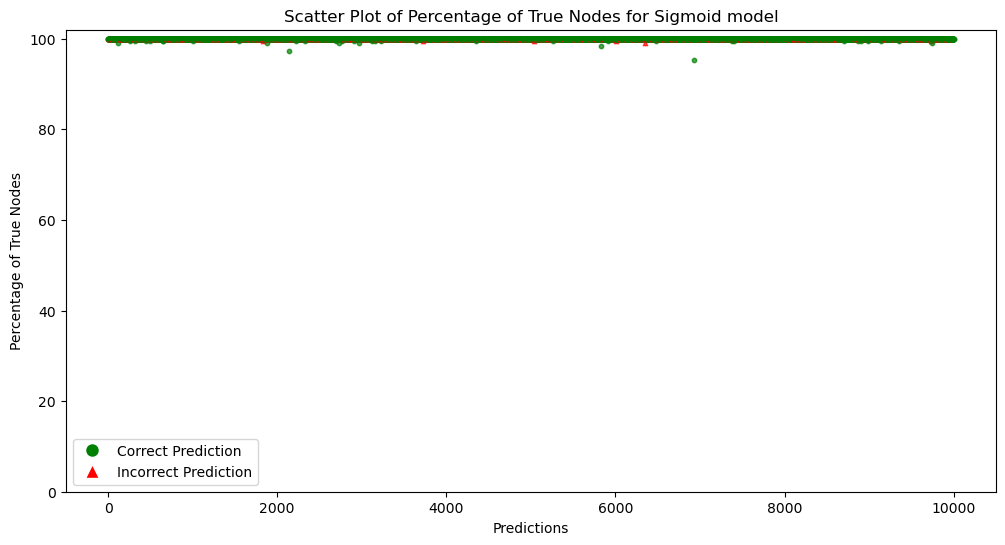

In [15]:
plot_percentage_scatter(percent_list_sigmoid, prediction_list_sigmoid, num_points=None, ymin=0, ymax=102,
                       title = "Scatter Plot of Percentage of True Nodes for Sigmoid model")

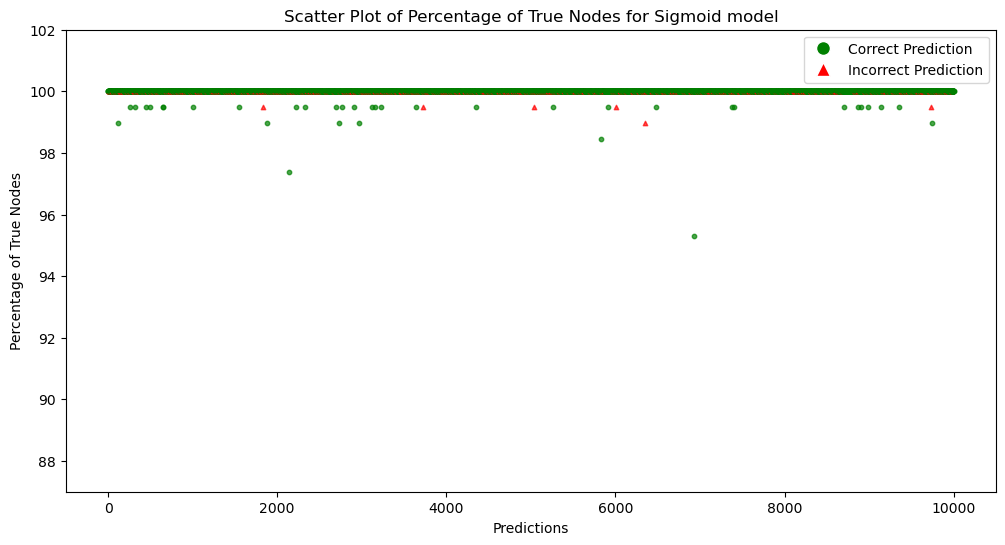

In [16]:
plot_percentage_scatter(percent_list_sigmoid, prediction_list_sigmoid, num_points=None, ymin=87, ymax=102,
                       title = "Scatter Plot of Percentage of True Nodes for Sigmoid model")

In [17]:
r_pb, p_value = pointbiserialr(prediction_list_sigmoid, percent_list_sigmoid)
r_pb, p_value

(0.008360465248752813, 0.40317930708300076)

#### Experiment 2: Trimming with percentage p

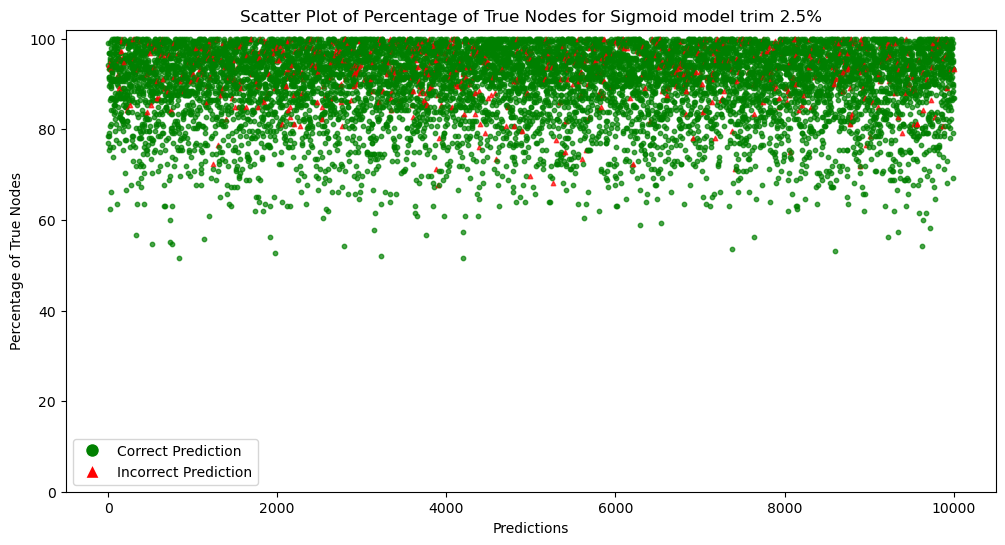

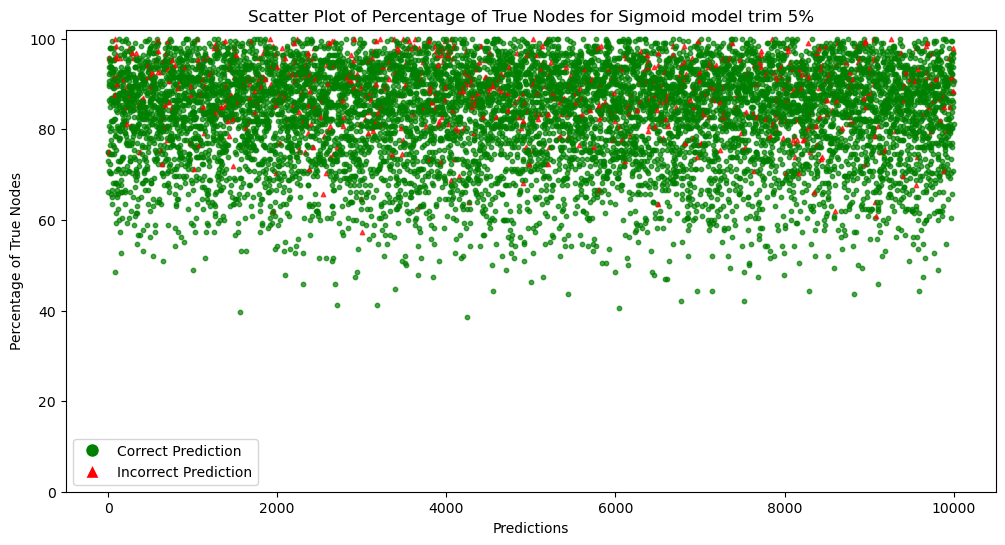

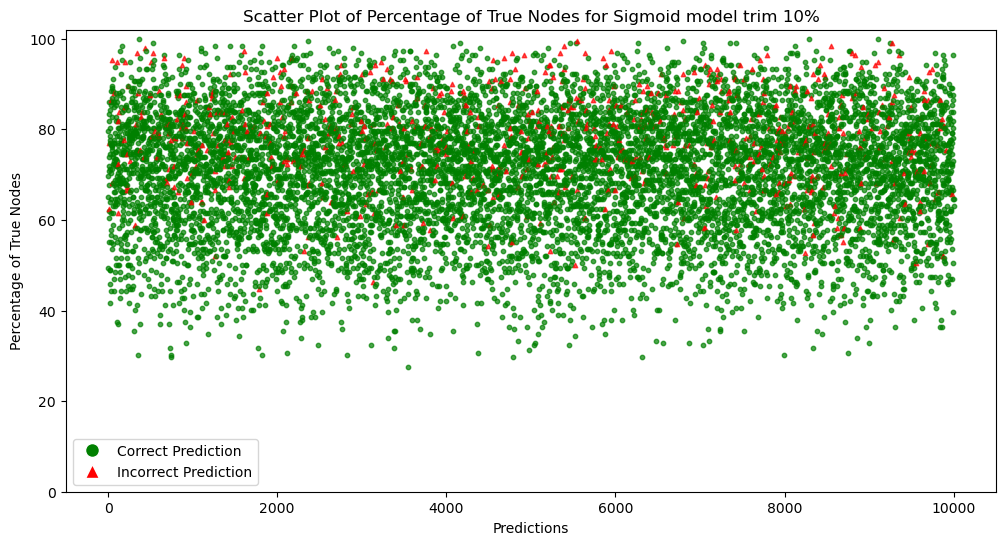

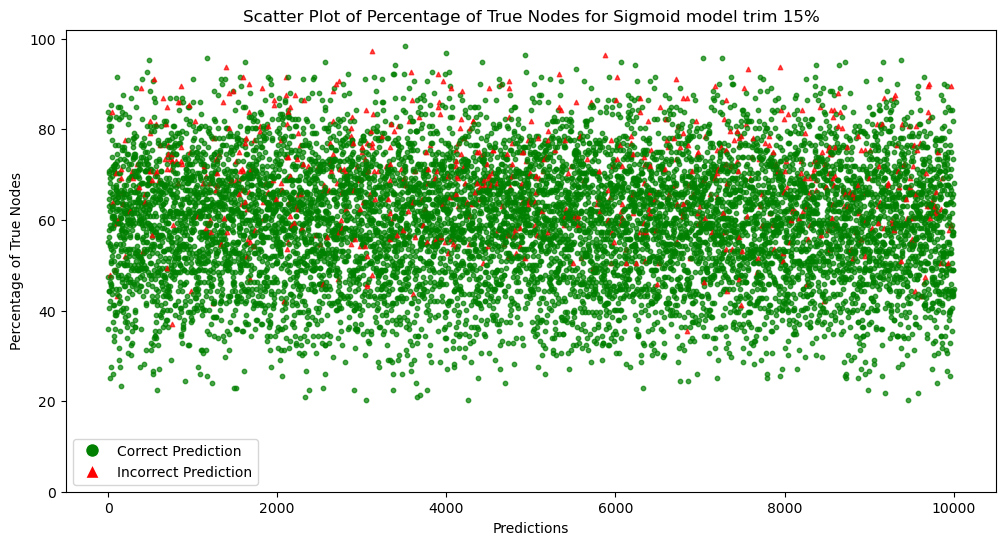

Percent 2.5 has correlation -0.07922095943723875 and pvalue 2.1292365635789046e-15
Percent 5 has correlation -0.11143566712430814 and pvalue 5.284678734077556e-29
Percent 10 has correlation -0.1481164958448227 and pvalue 3.71462860254237e-50
Percent 15 has correlation -0.17789307229181162 and pvalue 6.844436275161313e-72


In [18]:
percent_trim_list = [2.5,5,10,15]
correlation_list = []
for percent in percent_trim_list:
    accuracy_sigmoid, percent_list_sigmoid, prediction_list_sigmoid = evaluate_model_trim(model_sigmoid, valloader, percent = percent)
    plot_percentage_scatter(percent_list_sigmoid, prediction_list_sigmoid, num_points=None, ymin=0, ymax=102,
                       title = f"Scatter Plot of Percentage of True Nodes for Sigmoid model trim {percent}%")
    r_pb, p_value = pointbiserialr(prediction_list_sigmoid, percent_list_sigmoid)
    correlation_list.append((r_pb, p_value))

for i,percent in enumerate(percent_trim_list):
    print(f"Percent {percent} has correlation {correlation_list[i][0]} and pvalue {correlation_list[i][1]}")
    

#### Experiment 3: Trim using mean and std

In [ ]:
# cut using standard deviation
accuracy_sigmoid_trimmed, percent_list_sigmoid_trimmed, prediction_list_sigmoid_trimmed = evaluate_model(model_sigmoid, valloader, trim = True, n_std = 2)

Original =  172800000 node values
Trimmed =  170551331 node values
Values removed = 2248669
Percentage of nodes removed 1.3013130787037037


In [ ]:
# cut using standard deviation
k_list = [0.5, 1, 1.5, 2, 2.5, 3]
# k_list = [1.5]
correlation_list=[]
for k in k_list:
    accuracy_sigmoid_trimmed, percent_list_sigmoid_trimmed, prediction_list_sigmoid_trimmed = evaluate_model(model_sigmoid, 
                                                                                                             valloader, trim = True, 
                                                                                                             n_std = k)
    plot_percentage_scatter(percent_list_sigmoid_trimmed, prediction_list_sigmoid_trimmed, num_points=None, ymin=0, ymax=102,
                       title = f"Scatter Plot of Percentage of True Nodes for Sigmoid model with trimmed node values(std={k})")
    r_pb, p_value = pointbiserialr(prediction_list_sigmoid_trimmed, percent_list_sigmoid_trimmed)
    correlation_list.append((r_pb, p_value))
for i, tup in enumerate(correlation_list):
    print(f"For std = {k_list[i]}, correlation = {tup[0]} with pvalue {tup[1]}")
    

In [ ]:
# cut using standard deviation

accuracy_sigmoid_trimmed, percent_list_sigmoid_trimmed, prediction_list_sigmoid_trimmed = evaluate_model(model_sigmoid, 
                                                                                                         valloader, trim = True, 
                                                                                                         n_std = 1.5)
plot_percentage_scatter(percent_list_sigmoid_trimmed, prediction_list_sigmoid_trimmed, num_points=None, ymin=50, ymax=102,
                       title = f"Scatter Plot of Percentage of True Nodes for Sigmoid model with trimmed node values(std=1.5)")
    

# RELU model

In [ ]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

def create_network_dict(num_nodes_per_layer):
    network_dict = {}
    for layer in range(1, len(num_nodes_per_layer) + 1):
        layer_name = f"Layer{layer}"
        network_dict[layer_name] = {f"node{i}": [] for i in range(num_nodes_per_layer[layer - 1])}
    return network_dict

class MyModel_relu(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MyModel_relu, self).__init__()

        self.layer1 = nn.Linear(input_size, hidden_sizes[0])
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(hidden_sizes[1], output_size)
        self.log_softmax = nn.LogSoftmax(dim=1)
        self.node_dict = create_network_dict(num_nodes_per_layer=hidden_sizes)
        self.node_dict_testing = create_network_dict(num_nodes_per_layer=hidden_sizes)
        self.testing = False
        self.hidden_sizes = hidden_sizes
        self.node_dict_trimmed = create_network_dict(num_nodes_per_layer=hidden_sizes)
        self.record = True

    def record_node_values(self, x, layer, hidden_sizes, record):
        if record:
            if self.testing:
                for j in range(len(x[0])):
                    self.node_dict_testing[f"Layer{layer}"][f"node{j}"].extend(x[:, j].detach().cpu().numpy())
            else:
                for j in range(len(x[0])):
                    self.node_dict[f"Layer{layer}"][f"node{j}"].extend(x[:, j].detach().cpu().numpy())

    def forward(self, x):
        layer = 1
        x = self.relu1(self.layer1(x))
        self.record_node_values(x, layer, hidden_sizes, self.record)
        layer+=1
        x = self.relu2(self.layer2(x))
        self.record_node_values(x, layer, hidden_sizes, self.record)
        x = self.log_softmax(self.layer3(x))
        return x

    def reset_testing_dict(self):
        self.node_dict_testing = create_network_dict(num_nodes_per_layer=hidden_sizes)
        
    def trim_node_values(self, n_std = 2):
        for layer, subdict in self.node_dict.items():
            for node, values in subdict.items():
                values_array = np.array(values)
                mean = np.mean(values_array)
                std = np.std(values_array)
                filtered_values_array = values_array[(mean - n_std * std <= values_array) & (values_array <= mean + n_std * std)].tolist()
                self.node_dict_trimmed[layer][node] = filtered_values_array
       

model_relu = MyModel_relu(input_size, hidden_sizes, output_size)
device = torch.device('cuda')  # use cuda or cpu
model_relu.to(device)
print(model_relu)
optimizer = optim.SGD(model_relu.parameters(), lr=0.003, momentum=0.9)
criterion = nn.NLLLoss()
train_model(model_relu, trainloader, criterion, optimizer,  epochs=15)

In [ ]:
accuracy_relu, percent_list_relu, prediction_list_relu = evaluate_model(model_relu, valloader, trim = False, n_std = 2)
print(f"Model Accuracy = {accuracy_relu * 100}%")

In [ ]:
r_pb, p_value = pointbiserialr(prediction_list_relu, percent_list_relu)
r_pb, p_value

In [ ]:
plot_percentage_scatter(percent_list_relu, prediction_list_relu, num_points=None, ymin=0, ymax=102,
                       title = "Scatter Plot of Percentage of True Nodes for Relu model")

In [ ]:
plot_percentage_scatter(percent_list_relu, prediction_list_relu, num_points=None, ymin=78, ymax=102,
                       title = "Scatter Plot of Percentage of True Nodes for Relu model")

## Adversarial Attack

#### Sigmoid model

Creation of adversarial images

In [ ]:
from torchvision import transforms
epsilons = [0, .05, .1, .15, .2, .25, .3]
# epsilons = [0.1]
use_cuda=True
# Set random seed for reproducibility
torch.manual_seed(42)
test_loader = valloader
model_sigmoid.eval()
model_sigmoid.record = False #avoid recording node values while generating images
# FGSM attack code

def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

# restores the tensors to their original scale
def denorm(batch, mean=[0.5], std=[0.5]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)


def test(model, device, test_loader, epsilon):
    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all batches in the test set
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Iterate over each image in the batch
        for index_to_test in range(images.shape[0]):
            img = images[index_to_test].view(1, -1)
            img.requires_grad = True
            target = labels[index_to_test]
            output = model(img)
            ps = torch.exp(output)
            pred_label = torch.argmax(ps, 1).item()
            true_label = target.item()

            if pred_label != true_label:
                continue

            # Calculate the loss
            loss = criterion(output, target.unsqueeze(0))

            # Zero all existing gradients
            model.zero_grad()

            # Calculate gradients of model in backward pass
            loss.backward()

            # Collect data gradient
            data_grad = img.grad.data

            # FGSM Attack
            perturbed_data = fgsm_attack(img, epsilon, data_grad)

            # Re-classify the perturbed image
            output = model(perturbed_data)

            # Check for success
            ps = torch.exp(output)
            final_pred = torch.argmax(ps, 1).item()
            if final_pred == true_label:
                correct += 1
                # Special case for saving 0 epsilon examples
#                 if epsilon == 0 and len(adv_examples) < 5:
#                     adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
#                     adv_examples.append((pred_label, final_pred, adv_ex))
            else:
                # Save some adv examples for visualization later
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((pred_label, final_pred, adv_ex))

    # Calculate final accuracy for this epsilon
    final_acc = correct / float(len(test_loader.dataset))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader.dataset)} = {final_acc}")

    # Return the accuracy and adversarial examples
    return final_acc, adv_examples

accuracies_sigmoid = []
examples_sigmoid = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model_sigmoid, device, test_loader, eps)
    accuracies_sigmoid.append(acc)
    examples_sigmoid.append(ex)
    
model_sigmoid.record = True
    

In [ ]:
# # Plot several examples of adversarial samples at each epsilon
# cnt = 0
# plt.figure(figsize=(8,10))
# for i in range(len(epsilons)):
#     for j in range(len(examples[i])):
#         cnt += 1
#         plt.subplot(len(epsilons),len(examples[0]),cnt)
#         plt.xticks([], [])
#         plt.yticks([], [])
#         if j == 0:
#             plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
#         orig,adv,ex = examples[i][j]
#         ex=np.reshape(ex, (28,28))
#         plt.title(f"{orig} -> {adv}")
        
#         plt.imshow(ex, cmap="gray")
# plt.tight_layout()
# plt.show()

In [ ]:
def evaluate_model_perturbed_trim_percent(model, perturbed_images, valloader, percent = 5):
    device='cuda'
    hidden_sizes = model.hidden_sizes
    value_ranges = extract_node_value_ranges_trim(model, hidden_sizes, percent=percent)
    model.eval()
    model.testing = True
    model.reset_testing_dict()
    node_count = np.sum([len(subdict) for subdict in model.node_dict_testing.values()])

    correct_count, all_count = 0, 0
    percent_list = []
    prediction_list = []

    for i in range(len(perturbed_images)):
        images = torch.tensor(perturbed_images[i][2])
        labels = torch.tensor(perturbed_images[i][0])
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            images = images.view(1, -1)
            logps = model(images)

            true_count = 0
            for layer, subdict in model.node_dict_testing.items():
                for node, values in subdict.items():
                    min_value, max_value = value_ranges[layer][node]
                    if min_value <= values[all_count] <= max_value:
                        true_count += 1

            all_count += 1
            percent_true = true_count / node_count * 100
            percent_list.append(percent_true)
            true_count = 0

            ps = torch.exp(logps)
            probab = list(ps.detach().cpu().numpy()[0])
            pred_label = probab.index(max(probab))
            true_label = labels.detach().cpu().numpy()

            if true_label == pred_label:
                prediction_list.append(True)
                correct_count += 1
            else:
                prediction_list.append(False)
                
    accuracy = correct_count / all_count if all_count > 0 else 0.0
    acc_normal, percent_normal, pred_normal = evaluate_model_trim(model,valloader, percent = percent, len_test = len(perturbed_images))
    print(len(prediction_list))
    print(len(pred_normal))
    percent_list.extend(percent_normal)
    prediction_list.extend(pred_normal)
    #we shuffle the lists for better plots
    random.shuffle(percent_list)
    random.shuffle(prediction_list) 
    return accuracy,percent_list,prediction_list



In [ ]:
def evaluate_model_perturbed(model, perturbed_images, trim = False, n_std = 2):
    device='cuda'
    hidden_sizes = model.hidden_sizes
    value_ranges = extract_node_value_ranges(model, num_nodes_per_layer=hidden_sizes, trim = trim, n_std = n_std)
    model.eval()
    model.testing = True
    model.reset_testing_dict()
    node_count = np.sum([len(subdict) for subdict in model.node_dict_testing.values()])

    correct_count, all_count = 0, 0
    percent_list = []
    prediction_list = []

    for i in range(len(perturbed_images)):
        images = torch.tensor(perturbed_images[i][2])
        labels = torch.tensor(perturbed_images[i][0])
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            images = images.view(1, -1)
            logps = model(images)

            true_count = 0
            for layer, subdict in model.node_dict_testing.items():
                for node, values in subdict.items():
                    min_value, max_value = value_ranges[layer][node]
                    if min_value <= values[all_count] <= max_value:
                        true_count += 1

            all_count += 1
            percent_true = true_count / node_count * 100
            percent_list.append(percent_true)
            true_count = 0

            ps = torch.exp(logps)
            probab = list(ps.detach().cpu().numpy()[0])
            pred_label = probab.index(max(probab))
            true_label = labels.detach().cpu().numpy()

            if true_label == pred_label:
                prediction_list.append(True)
                correct_count += 1
            else:
                prediction_list.append(False)
                
    accuracy = correct_count / all_count if all_count > 0 else 0.0
    acc_normal, percent_normal, pred_normal = evaluate_model(model,valloader, trim = True, n_std = n_std, len_test = len(perturbed_images))
    print(len(prediction_list))
    print(len(pred_normal))
    percent_list.extend(percent_normal)
    prediction_list.extend(pred_normal)
    #we shuffle the lists for better plots
    random.shuffle(percent_list)
    random.shuffle(prediction_list) 
    return accuracy,percent_list,prediction_list



In [ ]:
plt.imshow(examples_sigmoid[0][i][2].numpy().squeeze(), cmap='gray_r');

In [ ]:
# examples[0][i][0] = target
# examples[0][i][2] = image
d = {}
for i in range(len(epsilons)):
    
    accuracy_sigmoid_perturbed, percent_list_sigmoid_perturbed, prediction_list_sigmoid_perturbed = evaluate_model_perturbed_trim_percent(model_sigmoid, 
                                                                                                                    examples_sigmoid[i],  
                                                                                                                    valloader,percent = None)
    d[i] = percent_list_sigmoid_perturbed,prediction_list_sigmoid_perturbed

In [ ]:
for i,tup in d.items():
    plot_percentage_scatter(tup[0], tup[1], num_points=None, ymin=0, ymax=102,
                       title = f"Scatter Plot of Percentage of True Nodes for Sigmoid model with perturbed data (eps = {epsilons[i]})")

In [ ]:
for i,value in enumerate(d.values()):
    r_pb, p_value = pointbiserialr(value[0], value[1])
    print("For epsilon = ", epsilons[i], " we have", len(value[0]),"values. Correlation is", r_pb, "with pvalue", p_value)

#### Trim using percent 

In [ ]:
# examples[0][i][0] = target
# examples[0][i][2] = image
percent_list = [2.5,5,10,15]
correlation_list = []
# percent_list= [10]
for p in percent_list:
    accuracy_sigmoid_perturbed_trim, percent_list_sigmoid_perturbed_trim, prediction_list_sigmoid_perturbed_trim = evaluate_model_perturbed_trim_percent(model_sigmoid, 
                                                                                                                examples_sigmoid[4], valloader, percent = p)
    plot_percentage_scatter(percent_list_sigmoid_perturbed_trim, prediction_list_sigmoid_perturbed_trim, num_points=None, ymin=0, ymax=102,
                       title = f"Scatter Plot of Percentage of True Nodes with perturbed data (epsilon = {epsilons[4]}) trim {p}%")
    r_pb, p_value = pointbiserialr(prediction_list_sigmoid_perturbed_trim, percent_list_sigmoid_perturbed_trim)
    correlation_list.append((r_pb, p_value))

for i,percent in enumerate(percent_list):
    print(f"Percent {percent} has correlation {correlation_list[i][0]} and pvalue {correlation_list[i][1]}")
    

#### Trim using mean and std

In [ ]:
k_list = [0.5, 1, 1.5, 2, 2.5, 3]
correlation_list = []

for k in k_list:
    accuracy_sigmoid_perturbed, percent_list_sigmoid_perturbed, prediction_list_sigmoid_perturbed = evaluate_model_perturbed(model_sigmoid, 
                                                                                                                    examples_sigmoid[4],  
                                                                                                                    trim = True, n_std = k)
#     plot_percentage_scatter(percent_list_sigmoid_perturbed, prediction_list_sigmoid_perturbed, num_points=None, ymin=0, ymax=102,
#                            title = f"Scatter Plot of Percentage of True Nodes (trimmed) for Sigmoid model with perturbed data (eps = {epsilons[4]}, k = {k})")
    r_pb, p_value = pointbiserialr(prediction_list_sigmoid_perturbed, percent_list_sigmoid_perturbed)
    correlation_list.append((r_pb, p_value))

for i,k in enumerate(k_list):
    print(f"k {k} has correlation {correlation_list[i][0]} and pvalue {correlation_list[i][1]}")
    
    